In [42]:
library("data.table")
library("tidyverse")
library("cowplot")


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




In [178]:
df <- fread("/hps/nobackup/birney/users/saul/tmp/time_step0.08_n_states14_hmm.csv.gz")[str_detect(id, "icab_icab")]

In [242]:
df[, date := str_remove(id, "_.*$")]
df[, time_string := str_remove(id, sprintf("%s_", date)) |> str_remove("_.*$")]
df[, time_numeric_h := str_remove(time_string, "..$") |> as.numeric()]
df[, time_numeric_m := str_remove(time_string, "^..") |> as.numeric()]
df[, time_numeric := time_numeric_h + (time_numeric_m/60)]
df[, time_numeric_m := str_remove(time_string, "^..") |> as.numeric()]
df[, quadrant := str_remove(id, "^.*_(of|no)_") |> str_remove("_.*$")]
df[, tank_side := str_remove(id, "^.*_icab_icab_") |> str_remove("_.*$")]
df[, assay := str_remove(id, "_q.*$") |> str_remove("^.*_")]
df[, fish := str_remove(id, "^.*_")]

In [243]:
res <- df[, .(speed = mean(distance)), by = c("date", "time_numeric", "quadrant", "tank_side", "fish")]
head(res)

date,time_numeric,quadrant,tank_side,fish,speed
<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
20190611,13.51667,q1,R,ref,2.423928
20190611,13.51667,q1,R,test,2.218588
20190611,13.51667,q2,R,ref,2.068742
20190611,13.51667,q2,R,test,2.298235
20190611,13.51667,q3,R,ref,2.251248
20190611,13.51667,q3,R,test,1.997207


In [245]:
fit <- aov(speed ~ date + time_numeric + quadrant + tank_side, data = res)
anova_pvals <- broom::tidy(fit) |>
    filter(term != "Residuals") |>
    mutate(p.fdr = p.adjust(p.value, method = "fdr")) |>
    rstatix::add_significance(p.col = "p.fdr") |>
    mutate(p.fdr = signif(p.fdr, 3)) |>
    mutate(
        p_final = ifelse(
            p.fdr.signif == "ns",
            paste("p =", p.fdr),
            paste("p =", p.fdr, p.fdr.signif)
        )
    ) |>
    as.data.table()

anova_pvals

term,df,sumsq,meansq,statistic,p.value,p.fdr,p.fdr.signif,p_final
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
date,4,5.4384188,1.3596047,3.3193084,0.01271602,0.0254,*,p = 0.0254 *
time_numeric,1,0.1764625,0.1764625,0.4308117,0.51278784,0.5130,ns,p = 0.513
quadrant,3,4.7236231,1.5745410,3.8440491,0.01131216,0.0254,*,p = 0.0254 *
tank_side,1,1.2860348,1.2860348,3.1396965,0.07882518,0.1050,ns,p = 0.105


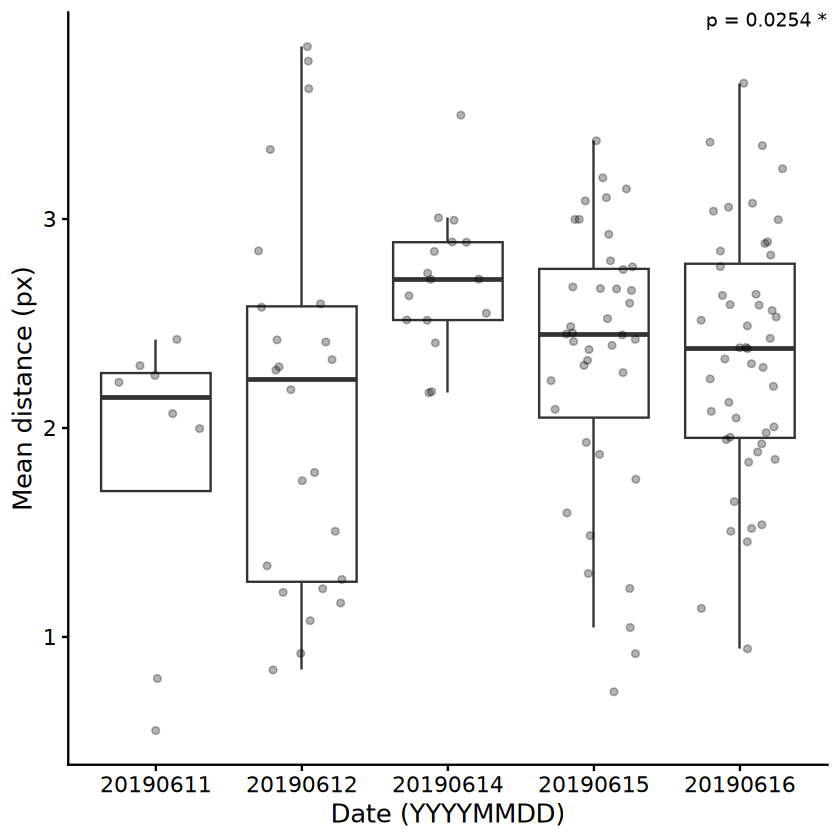

In [264]:
options(repr.plot.width = 7, repr.plot.height = 7)
p1 <- ggplot(res, aes(x = date, y = speed)) +
    geom_boxplot(outlier.shape =  NA) +
    geom_jitter(width = 0.3, height = 0, alpha = 0.3) + 
    theme_cowplot(15) +
    labs(x = "Date (YYYYMMDD)", y = "Mean distance (px)") +
    geom_text(data = anova_pvals[term == "date"], aes(label = p_final, x = Inf, y = Inf, hjust = 1, vjust = 1))

p1

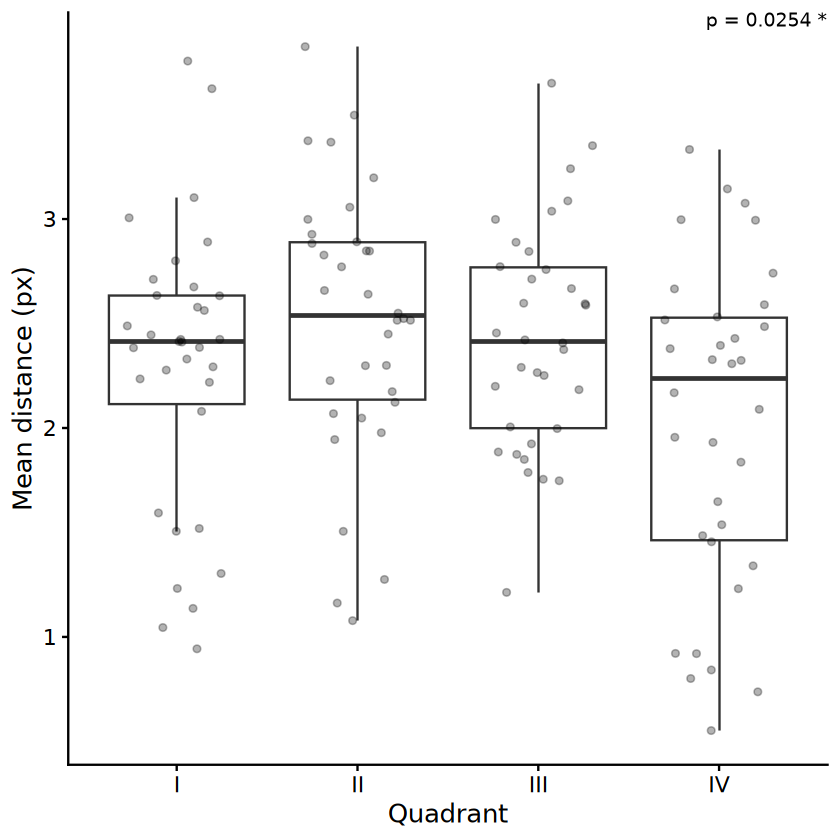

In [247]:
options(repr.plot.width = 7, repr.plot.height = 7)
p2 <- ggplot(res, aes(x = quadrant, y = speed)) +
    geom_boxplot(outlier.shape =  NA) +
    geom_jitter(width = 0.3, height = 0, alpha = 0.3) + 
    theme_cowplot(15) +
    labs(x = "Quadrant", y = "Mean distance (px)") +
    scale_x_discrete(labels = c("q1" = "I", "q2" = "II", "q3" = "III", "q4" = "IV")) +
    geom_text(data = anova_pvals[term == "quadrant"], aes(label = p_final, x = Inf, y = Inf, hjust = 1, vjust = 1))

p2

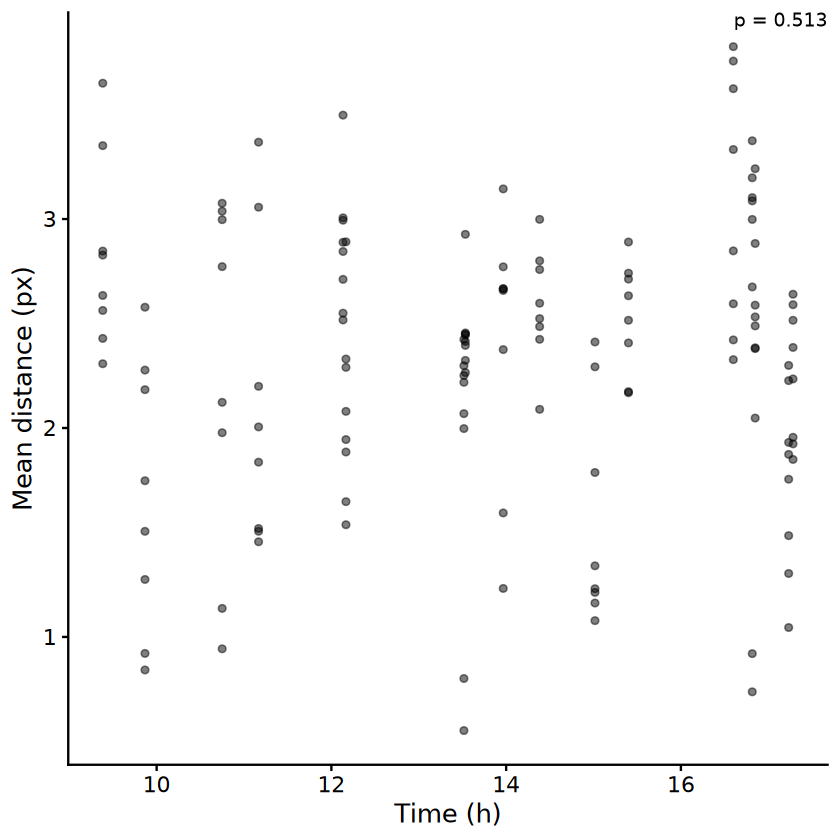

In [262]:
options(repr.plot.width = 7, repr.plot.height = 7)
p3 <- ggplot(res, aes(x = time_numeric, y = speed)) +
    geom_point(alpha = 0.5) + 
    theme_cowplot(15) +
    labs(x = "Time (h)", y = "Mean distance (px)") +
    geom_text(data = anova_pvals[term == "time_numeric"], aes(label = p_final, x = Inf, y = Inf, hjust = 1, vjust = 1))

p3

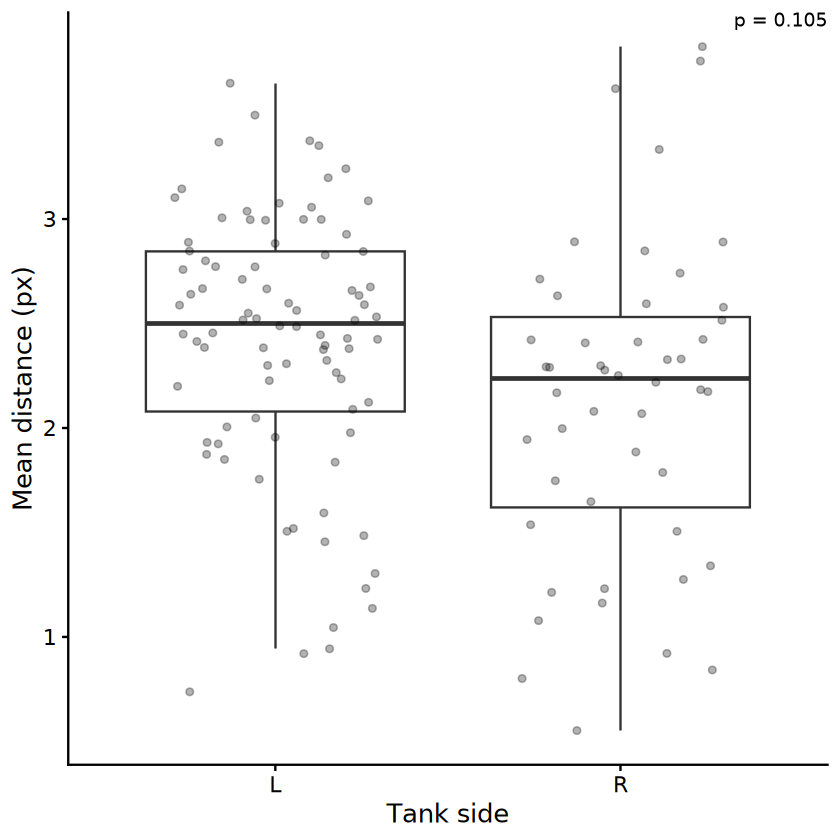

In [249]:
options(repr.plot.width = 7, repr.plot.height = 7)
p4 <- ggplot(res, aes(x = tank_side, y = speed)) +
    geom_boxplot(outlier.shape =  NA) +
    geom_jitter(width = 0.3, height = 0, alpha = 0.3) + 
    theme_cowplot(15) +
    labs(x = "Tank side", y = "Mean distance (px)") +
    geom_text(data = anova_pvals[term == "tank_side"], aes(label = p_final, x = Inf, y = Inf, hjust = 1, vjust = 1))
p4

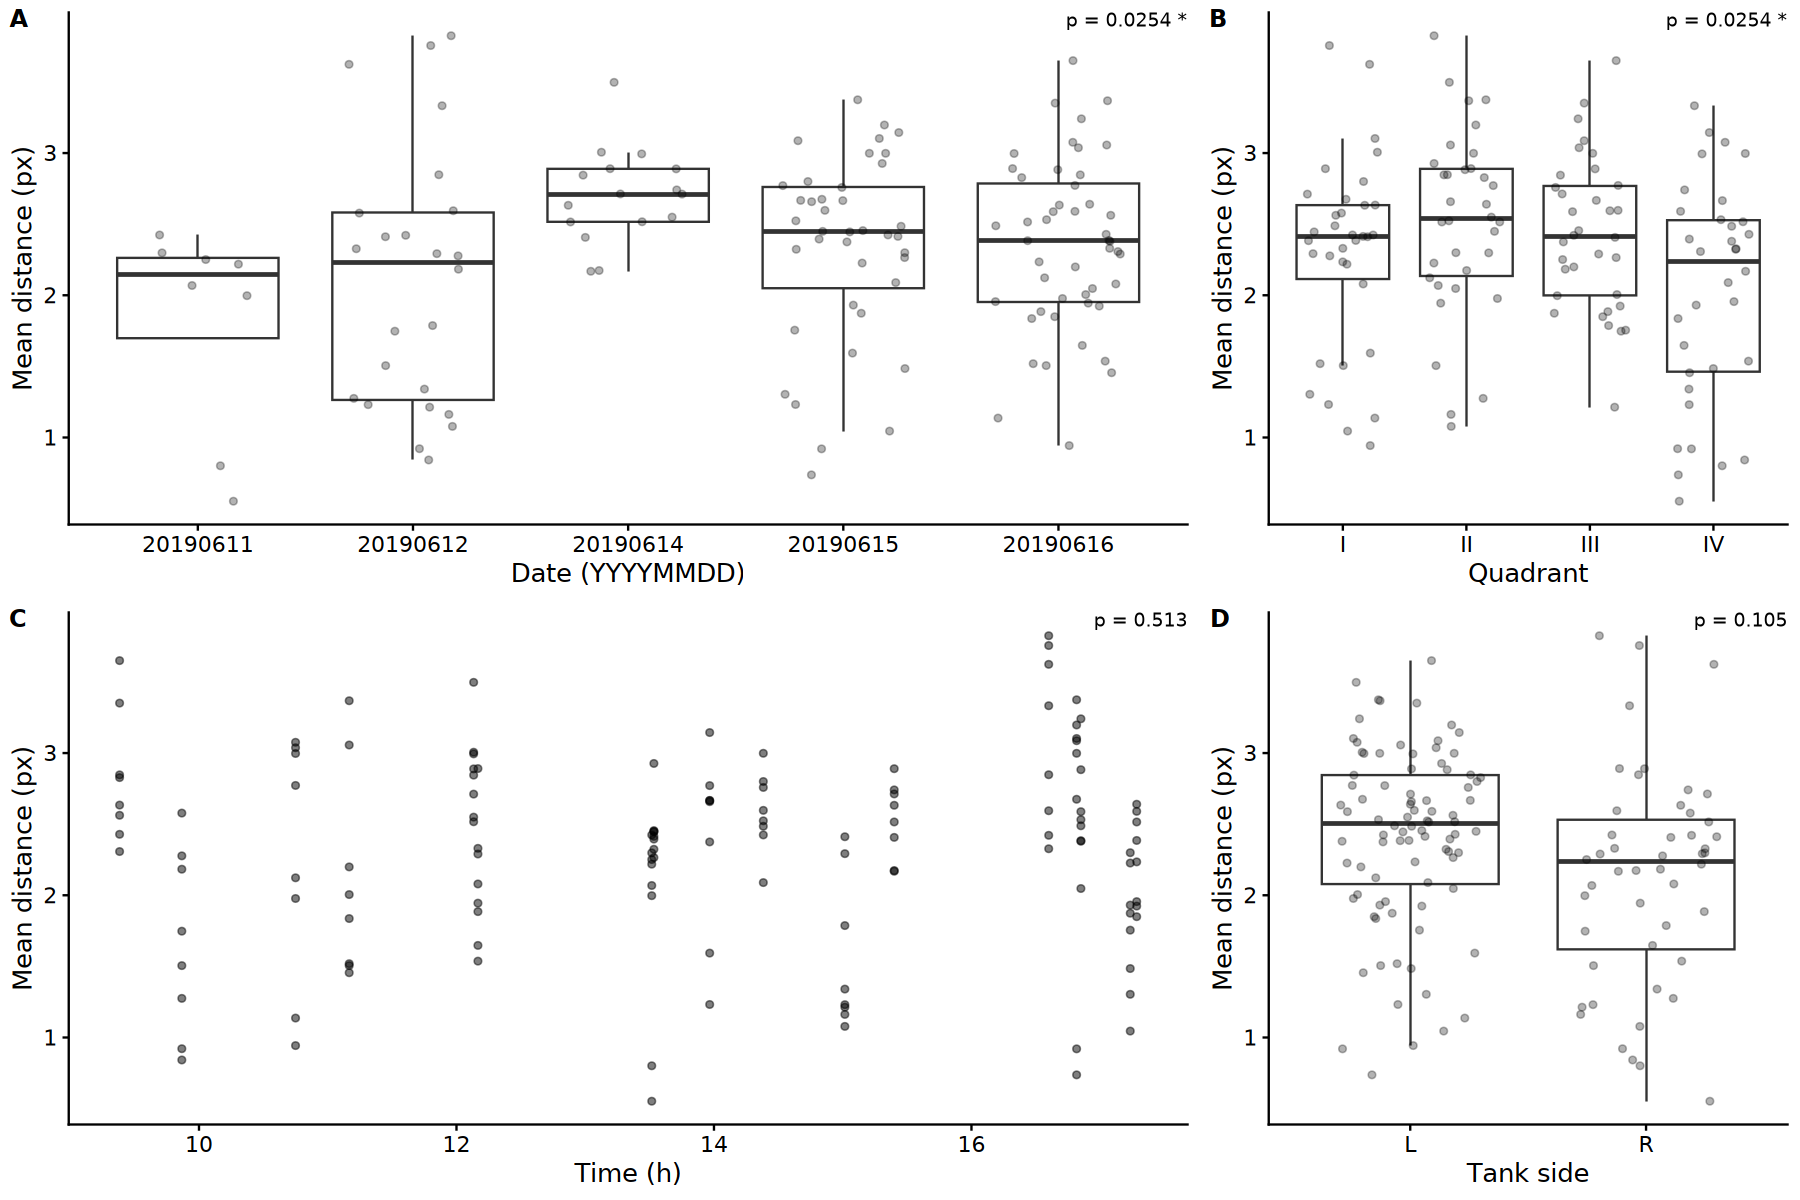

In [265]:
options(repr.plot.width = 15, repr.plot.height = 10)
p12 <- plot_grid(p1, p2, nrow = 1, rel_widths = c(2, 1), labels = c("A", "B"))
p34 <- plot_grid(p3, p4, nrow = 1, rel_widths = c(2, 1), labels = c("C", "D"))
p <- plot_grid(p12, p34, nrow = 2)
p

In [267]:
ggsave("fig2.png", p, width = 15, height = 10)